# Regression Analysis 

### Author_: Christian Rosado

In [734]:
# imports
from __future__  import print_function, division
import pylab as pl
import pandas as pd
import numpy as np
#from geopandas import GeoDataFrame
import geopandas as gpd
import matplotlib.pyplot as plt
from fiona.crs import from_epsg
import shapely as shp
import seaborn 
import os
import urllib
import requests
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Pulling Data via API
wifi_data = pd.read_json("http://wifindproject.com/wifipulling/?device_model=VS425")

In [3]:
wifi_data.head()

,acc,altitude,app_version,bssid,caps,device_mac,device_model,droid_version,freq,idx,lat,level,lng,ssid,time
0,19.957,0.0,0.3.3,1c:e8:5d:ca:8f:33,[wpa-eap-tkip][wpa2-eap-ccmp][ess],d3a2898a5e731607,VS425,5.1.1,2437,56629534,40.690966,-60,-73.987686,nyu-legacy,1497296993826
1,19.957,0.0,0.3.3,1c:e8:5d:ca:8f:32,[wpa2-eap-ccmp][ess],d3a2898a5e731607,VS425,5.1.1,2437,56629535,40.690966,-59,-73.987686,eduroam,1497296993826
2,19.957,0.0,0.3.3,cc:d5:39:27:f2:43,[wpa-eap-tkip][wpa2-eap-ccmp][ess],d3a2898a5e731607,VS425,5.1.1,2412,56629536,40.690966,-66,-73.987686,nyu-legacy,1497296993826
3,19.957,0.0,0.3.3,cc:d5:39:27:f2:42,[wpa2-eap-ccmp][ess],d3a2898a5e731607,VS425,5.1.1,2412,56629537,40.690966,-67,-73.987686,eduroam,1497296993826
4,19.957,0.0,0.3.3,00:a2:ee:03:e3:20,[wpa2-eap-ccmp][ess],d3a2898a5e731607,VS425,5.1.1,2412,56629538,40.690966,-73,-73.987686,constitution,1497296993826


In [4]:
# filter records with accuaracy scores of 50 and above
wifi_data = wifi_data.drop(wifi_data[wifi_data.acc > 50].index)

In [5]:
wifi_data.head()

,acc,altitude,app_version,bssid,caps,device_mac,device_model,droid_version,freq,idx,lat,level,lng,ssid,time
0,19.957,0.0,0.3.3,1c:e8:5d:ca:8f:33,[wpa-eap-tkip][wpa2-eap-ccmp][ess],d3a2898a5e731607,VS425,5.1.1,2437,56629534,40.690966,-60,-73.987686,nyu-legacy,1497296993826
1,19.957,0.0,0.3.3,1c:e8:5d:ca:8f:32,[wpa2-eap-ccmp][ess],d3a2898a5e731607,VS425,5.1.1,2437,56629535,40.690966,-59,-73.987686,eduroam,1497296993826
2,19.957,0.0,0.3.3,cc:d5:39:27:f2:43,[wpa-eap-tkip][wpa2-eap-ccmp][ess],d3a2898a5e731607,VS425,5.1.1,2412,56629536,40.690966,-66,-73.987686,nyu-legacy,1497296993826
3,19.957,0.0,0.3.3,cc:d5:39:27:f2:42,[wpa2-eap-ccmp][ess],d3a2898a5e731607,VS425,5.1.1,2412,56629537,40.690966,-67,-73.987686,eduroam,1497296993826
4,19.957,0.0,0.3.3,00:a2:ee:03:e3:20,[wpa2-eap-ccmp][ess],d3a2898a5e731607,VS425,5.1.1,2412,56629538,40.690966,-73,-73.987686,constitution,1497296993826


# Needed variables:
* Total Population
* Population Density
* House Hold Density
* Median Household Income
* Wifi Counts (open and other)
* Location (lat, long)
    

In [1063]:
# 2010 & 2000 pop by census tract - BK
#NYC_pop_data = pd.read_json("https://data.cityofnewyork.us/resource/rx2e-87id.json", dtype={'census_tract': str})
NYC_pop_data = pd.read_csv("https://data.cityofnewyork.us/api/views/rx2e-87id/rows.csv?accessType=DOWNLOAD", dtype={'Census Tract': str})

In [1064]:
NYC_pop_data.shape

(1522, 6)

In [1065]:
NYC_pop_data.head()

,Borough,Year,FIPS County Code,DCP Borough Code,Census Tract,Population
0,Brooklyn,2000,47,3,000100,5498
1,Brooklyn,2000,47,3,000200,1303
2,Brooklyn,2000,47,3,000301,5036
3,Brooklyn,2000,47,3,000501,3415
4,Brooklyn,2000,47,3,000502,2739


In [1066]:
NYC_pop_data.drop(NYC_pop_data[NYC_pop_data.Year == 2000].index, inplace=True)

In [1067]:
NYC_pop_data.head()

,Borough,Year,FIPS County Code,DCP Borough Code,Census Tract,Population
761,Brooklyn,2010,47,3,000100,4338
762,Brooklyn,2010,47,3,000200,1470
763,Brooklyn,2010,47,3,000301,4259
764,Brooklyn,2010,47,3,000501,4247
765,Brooklyn,2010,47,3,000502,2512


In [1068]:
NYC_pop_data.shape

(761, 6)

In [1069]:
NYC_pop_data["boro_ct2010"] = NYC_pop_data["DCP Borough Code"].astype(str) + NYC_pop_data["Census Tract"].astype(str)

In [1070]:
NYC_pop_data["boro_ct2010"] = NYC_pop_data["boro_ct2010"].astype(int)

In [1071]:
NYC_pop_data["boro_ct2010"].dtype

dtype('int64')

In [1072]:
NYC_pop_data.Borough.unique()

array(['Brooklyn'], dtype=object)

In [1073]:
# 6 digits
# leading with 2 zeros for 2 digit numbers
# leading with 1 zeros for 3 digit numbers
# ending with 2 zeros for decimal places

NYC_pop_data[NYC_pop_data["Census Tract"].str.contains("0")].head()

,Borough,Year,FIPS County Code,DCP Borough Code,Census Tract,Population,boro_ct2010
761,Brooklyn,2010,47,3,000100,4338,3000100
762,Brooklyn,2010,47,3,000200,1470,3000200
763,Brooklyn,2010,47,3,000301,4259,3000301
764,Brooklyn,2010,47,3,000501,4247,3000501
765,Brooklyn,2010,47,3,000502,2512,3000502


In [1074]:
NYC_pop_data.shape

(761, 7)

In [1075]:
# 2010 Census Tracts - NYC Open Data
# https://data.cityofnewyork.us/City-Government/2010-Census-Tracts/fxpq-c8ku

"""REFERENCE SYSTEM IDENTIFIER
* VALUE 2263
* CODESPACE EPSG
* VERSION 8.6.2"""

#data = requests.get("https://data.cityofnewyork.us/resource/i69b-3rdj.json")
#data = "https://data.cityofnewyork.us/api/views/i69b-3rdj/rows.csv?accessType=DOWNLOAD"
#df = pd.read_csv(data)
gdf = gpd.GeoDataFrame.from_file("../Downloads/2010_Census_Tracts/geo_export_8ad4f19d-1ddb-439a-86bc-803d35337ad4.shp") #(data.json())
gdf.head()

,boro_code,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,geometry,ntacode,ntaname,puma,shape_area,shape_leng
0,5,5000900,Staten Island,I,000900,9,POLYGON ((-74.07920577013245 40.64343078374567...,SI22,West New Brighton-New Brighton-St. George,3903,2.497010e+06,7729.016794
1,1,1009800,Manhattan,I,009800,98,POLYGON ((-73.96432543478758 40.75638153099091...,MN19,Turtle Bay-East Midtown,3808,1.906016e+06,5534.199811
2,1,1010000,Manhattan,I,010000,100,POLYGON ((-73.96802436915851 40.75957814005282...,MN19,Turtle Bay-East Midtown,3808,1.860938e+06,5692.168737
3,1,1010200,Manhattan,I,010200,102,POLYGON ((-73.97124277307127 40.76093641847906...,MN17,Midtown-Midtown South,3807,1.860993e+06,5687.802439
4,1,1010400,Manhattan,I,010400,104,POLYGON ((-73.97445730550224 40.76229308352487...,MN17,Midtown-Midtown South,3807,1.864600e+06,5693.036367


In [1076]:
gdf["boro_ct2010"] = gdf["boro_ct201"].astype(int)

In [1077]:
gdf[gdf.boro_code == "3"].shape

(760, 13)

In [1078]:
#country_shapes = country_shapes.merge(country_names, on='iso_a3')
NYC_shape = gdf.merge(NYC_pop_data, on="boro_ct2010")

In [1079]:
NYC_shape.shape

(760, 19)

In [1080]:
NYC_shape.head()

,boro_code,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,geometry,ntacode,ntaname,puma,shape_area,shape_leng,boro_ct2010,Borough,Year,FIPS County Code,DCP Borough Code,Census Tract,Population
0,3,3000501,Brooklyn,I,000501,5.01,"POLYGON ((-73.99301822153384 40.6974623645668,...",BK09,Brooklyn Heights-Cobble Hill,4004,9.015070e+05,4828.169912,3000501,Brooklyn,2010,47,3,000501,4247
1,3,3002000,Brooklyn,I,002000,20,POLYGON ((-74.01266264860631 40.64925555478156...,BK32,Sunset Park West,4012,1.620770e+06,5426.067279,3002000,Brooklyn,2010,47,3,002000,1672
2,3,3004100,Brooklyn,I,004100,41,POLYGON ((-73.98181677448231 40.68732980276495...,BK38,DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill,4004,1.744094e+06,5283.856660,3004100,Brooklyn,2010,47,3,004100,3598
3,3,3005202,Brooklyn,I,005202,52.02,POLYGON ((-74.03809447949381 40.62058489897851...,BK31,Bay Ridge,4013,1.398134e+06,5190.713818,3005202,Brooklyn,2010,47,3,005202,2481
4,3,3005800,Brooklyn,E,005800,58,POLYGON ((-74.02956408409689 40.61983253935202...,BK31,Bay Ridge,4013,2.080303e+06,6098.167799,3005800,Brooklyn,2010,47,3,005800,3152


In [1081]:
NYC_shape.Population.dtype

dtype('int64')

In [1082]:
NYC_shape.shape_area.dtype

dtype('float64')

In [1083]:
NYC_shape.head()

,boro_code,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,geometry,ntacode,ntaname,puma,shape_area,shape_leng,boro_ct2010,Borough,Year,FIPS County Code,DCP Borough Code,Census Tract,Population
0,3,3000501,Brooklyn,I,000501,5.01,"POLYGON ((-73.99301822153384 40.6974623645668,...",BK09,Brooklyn Heights-Cobble Hill,4004,9.015070e+05,4828.169912,3000501,Brooklyn,2010,47,3,000501,4247
1,3,3002000,Brooklyn,I,002000,20,POLYGON ((-74.01266264860631 40.64925555478156...,BK32,Sunset Park West,4012,1.620770e+06,5426.067279,3002000,Brooklyn,2010,47,3,002000,1672
2,3,3004100,Brooklyn,I,004100,41,POLYGON ((-73.98181677448231 40.68732980276495...,BK38,DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill,4004,1.744094e+06,5283.856660,3004100,Brooklyn,2010,47,3,004100,3598
3,3,3005202,Brooklyn,I,005202,52.02,POLYGON ((-74.03809447949381 40.62058489897851...,BK31,Bay Ridge,4013,1.398134e+06,5190.713818,3005202,Brooklyn,2010,47,3,005202,2481
4,3,3005800,Brooklyn,E,005800,58,POLYGON ((-74.02956408409689 40.61983253935202...,BK31,Bay Ridge,4013,2.080303e+06,6098.167799,3005800,Brooklyn,2010,47,3,005800,3152


In [1084]:
#from fiona.crs import from_epsg
#ct_shape.crs = from_epsg(4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
#NYC_Area=ct_shape.to_crs(epsg=2263).geometry.area.sum()/(2.788*10**7) # from ft2 to mi2 
#print 'total NYC land area: %s (mi^2)'%str(NYC_Area)[:5] # from ft2 to mi2 #epsg=2263 is US feet

In [1085]:
NYC_shape.crs = from_epsg(4326)

In [1086]:
NYC_shape.crs

{'init': 'epsg:4326', 'no_defs': True}

In [1087]:
# Population density by 1,000 sq feet
NYC_shape["pop_density"] = (NYC_shape.Population/NYC_shape.shape_area)*5280

In [1088]:
NYC_shape.head()

,boro_code,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,geometry,ntacode,ntaname,puma,shape_area,shape_leng,boro_ct2010,Borough,Year,FIPS County Code,DCP Borough Code,Census Tract,Population,pop_density
0,3,3000501,Brooklyn,I,000501,5.01,"POLYGON ((-73.99301822153384 40.6974623645668,...",BK09,Brooklyn Heights-Cobble Hill,4004,9.015070e+05,4828.169912,3000501,Brooklyn,2010,47,3,000501,4247,24.874084
1,3,3002000,Brooklyn,I,002000,20,POLYGON ((-74.01266264860631 40.64925555478156...,BK32,Sunset Park West,4012,1.620770e+06,5426.067279,3002000,Brooklyn,2010,47,3,002000,1672,5.446892
2,3,3004100,Brooklyn,I,004100,41,POLYGON ((-73.98181677448231 40.68732980276495...,BK38,DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill,4004,1.744094e+06,5283.856660,3004100,Brooklyn,2010,47,3,004100,3598,10.892438
3,3,3005202,Brooklyn,I,005202,52.02,POLYGON ((-74.03809447949381 40.62058489897851...,BK31,Bay Ridge,4013,1.398134e+06,5190.713818,3005202,Brooklyn,2010,47,3,005202,2481,9.369399
4,3,3005800,Brooklyn,E,005800,58,POLYGON ((-74.02956408409689 40.61983253935202...,BK31,Bay Ridge,4013,2.080303e+06,6098.167799,3005800,Brooklyn,2010,47,3,005800,3152,8.000064


In [1089]:
#building_data = pd.read_json("https://data.cityofnewyork.us/resource/q3m4-ttp3.json", dtype={'census_tract': str}) 

In [1090]:
# Shapefile: Median Household Income, Census Tract
#http://data.beta.nyc/dataset/median-household-income-2010-census-tracts/resource/92bbc70e-2b4e-40aa-8a1f-d39b11124b49

path = "../Downloads/medianhouseholdincomecensustract.csv"
house_data = pd.read_csv(path, dtype={'TRACTCE10': str})
house_data.head()

,FID,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,INTPTLAT10,INTPTLON10,State,COUNTY,HH_COUNT,...,MSMOC_TOT_,TAX_RET,Avg_TransC,REtaxperow,DISP_INC,energy_cos,REtax_ACS,AVG_TTL,LOCALNAME,Shape_Area
0,0,34,17,32400,34017032400,40.792844,-74.013482,New Jersey,Hudson County,2187,...,22740,2264.889916,4145.566539,4966.370331,12232.00950,1773.280152,7735,5007.444405,West New York Town,0.000036
1,1,34,17,10100,34017010100,40.691559,-74.110913,New Jersey,Hudson County,2255,...,27804,2363.430717,5969.286255,4490.984109,22077.84024,1876.844806,7917,6146.888195,Bayonne City,0.000106
2,2,34,17,10200,34017010200,40.682103,-74.104573,New Jersey,Hudson County,1218,...,28068,1260.718928,6014.489564,3339.224580,20488.60531,2167.175106,7692,6193.436421,Bayonne City,0.000031
3,3,34,17,10300,34017010300,40.672439,-74.081016,New Jersey,Hudson County,1093,...,22620,1229.562591,4798.787758,3793.386763,15514.61337,2163.964082,7831,4941.564294,Bayonne City,0.000108
4,4,34,17,10400,34017010400,40.670599,-74.089940,New Jersey,Hudson County,1571,...,20724,2209.874484,7611.970058,4478.110461,35131.00534,2114.480847,7918,7838.446154,Bayonne City,0.000234


In [1091]:
house_data.columns

Index(['FID', 'STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'GEOID10', 'INTPTLAT10',
       'INTPTLON10', 'State', 'COUNTY', 'HH_COUNT', 'OHU_OWN', 'OHU_RENT',
       'PERC_OWN', 'PERC_RENT', 'MHI', 'MED_VAL', 'HOUSINGCOS', 'MCR_ANNUAL',
       'MSMOC_TOT_', 'TAX_RET', 'Avg_TransC', 'REtaxperow', 'DISP_INC',
       'energy_cos', 'REtax_ACS', 'AVG_TTL', 'LOCALNAME', 'Shape_Area'],
      dtype='object')

In [1092]:
#house_data[house_data.TRACTCE10.str.contains("11")]

In [1093]:
#house_data["boro_ct2010"] = house_data.TRACTCE10.str.ljust(5,'0')

In [1094]:
house_data["boro_ct2010"] = house_data.TRACTCE10.str.zfill(6)

In [1095]:
house_data.head()

,FID,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,INTPTLAT10,INTPTLON10,State,COUNTY,HH_COUNT,...,TAX_RET,Avg_TransC,REtaxperow,DISP_INC,energy_cos,REtax_ACS,AVG_TTL,LOCALNAME,Shape_Area,boro_ct2010
0,0,34,17,32400,34017032400,40.792844,-74.013482,New Jersey,Hudson County,2187,...,2264.889916,4145.566539,4966.370331,12232.00950,1773.280152,7735,5007.444405,West New York Town,0.000036,032400
1,1,34,17,10100,34017010100,40.691559,-74.110913,New Jersey,Hudson County,2255,...,2363.430717,5969.286255,4490.984109,22077.84024,1876.844806,7917,6146.888195,Bayonne City,0.000106,010100
2,2,34,17,10200,34017010200,40.682103,-74.104573,New Jersey,Hudson County,1218,...,1260.718928,6014.489564,3339.224580,20488.60531,2167.175106,7692,6193.436421,Bayonne City,0.000031,010200
3,3,34,17,10300,34017010300,40.672439,-74.081016,New Jersey,Hudson County,1093,...,1229.562591,4798.787758,3793.386763,15514.61337,2163.964082,7831,4941.564294,Bayonne City,0.000108,010300
4,4,34,17,10400,34017010400,40.670599,-74.089940,New Jersey,Hudson County,1571,...,2209.874484,7611.970058,4478.110461,35131.00534,2114.480847,7918,7838.446154,Bayonne City,0.000234,010400


Manhattan - New York County. 1
Bronx - Bronx County. 2
Brooklyn - Kings County. 3
Queens - Queens County. 4
Staten Island - Richmond County. 5

In [1096]:
def boro(x):
    if x == "New York County":
        return 1
    if x == "Bronx County":
        return 2
    if x == "Kings County":
        return 3
    if x == "Queens County":
        return 4
    if x == "Richmond County":
        return 5

In [1097]:
boro('New York County')

1

In [1098]:
house_data.head()

,FID,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,INTPTLAT10,INTPTLON10,State,COUNTY,HH_COUNT,...,TAX_RET,Avg_TransC,REtaxperow,DISP_INC,energy_cos,REtax_ACS,AVG_TTL,LOCALNAME,Shape_Area,boro_ct2010
0,0,34,17,32400,34017032400,40.792844,-74.013482,New Jersey,Hudson County,2187,...,2264.889916,4145.566539,4966.370331,12232.00950,1773.280152,7735,5007.444405,West New York Town,0.000036,032400
1,1,34,17,10100,34017010100,40.691559,-74.110913,New Jersey,Hudson County,2255,...,2363.430717,5969.286255,4490.984109,22077.84024,1876.844806,7917,6146.888195,Bayonne City,0.000106,010100
2,2,34,17,10200,34017010200,40.682103,-74.104573,New Jersey,Hudson County,1218,...,1260.718928,6014.489564,3339.224580,20488.60531,2167.175106,7692,6193.436421,Bayonne City,0.000031,010200
3,3,34,17,10300,34017010300,40.672439,-74.081016,New Jersey,Hudson County,1093,...,1229.562591,4798.787758,3793.386763,15514.61337,2163.964082,7831,4941.564294,Bayonne City,0.000108,010300
4,4,34,17,10400,34017010400,40.670599,-74.089940,New Jersey,Hudson County,1571,...,2209.874484,7611.970058,4478.110461,35131.00534,2114.480847,7918,7838.446154,Bayonne City,0.000234,010400


In [1099]:
house_data["boro_code"] = house_data.COUNTY.map({"New York County": "1", "Bronx County": "2", "Kings County": "3", \
                                           "Queens County": "4", "Richmond County": "5"})

In [1100]:
house_data.boro_ct2010 = house_data.boro_code.astype(str) + house_data.boro_ct2010.astype(str)

In [1101]:
#house_data[house_data.boro_code == "3"]

In [1102]:
NYC_shape[NYC_shape.boro_ct2010 == 3074000]

,boro_code,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,geometry,ntacode,ntaname,puma,shape_area,shape_leng,boro_ct2010,Borough,Year,FIPS County Code,DCP Borough Code,Census Tract,Population,pop_density
224,3,3074000,Brooklyn,I,074000,740,POLYGON ((-73.93915724418619 40.62559953621171...,BK58,Flatlands,4009,1.747895e+06,5614.8792,3074000,Brooklyn,2010,47,3,074000,3531,10.666364


In [1103]:
#building_data["boro_ct2010"] = building_data.census_tract.str.ljust(5, '0')

In [1104]:
#building_data["boro_ct2010"] = building_data.boro_ct2010.str.zfill(6)

In [1105]:
#del building_data["great"]

In [1106]:
#building_data.tail()

In [1107]:
#building_data.boro_ct2010.dtype

In [1108]:
#building_data["great"] = building_data.boro_ct2010.str.len() > 6

In [1109]:
#building_data.shape

In [1110]:
#building_data.borough.unique()

In [1111]:
#building_data["boro_code"] = building_data.borough.map({"Manhattan": "1", "Bronx": "2", "Brooklyn": "3", \
                                          # "Queens": "4", "Staten Island": "5"})

In [1112]:
#building_data["boro_ct2010"] = building_data["boro_code"].astype(str) + building_data["boro_ct2010"].astype(str)

In [1113]:
#building_data.tail()

In [1114]:
#NYC_shape merge with house data merge with building_data

In [1115]:
NYC_shape.shape

(760, 20)

In [1116]:
NYC_shape.boro_ct2010.dtype

dtype('int64')

In [1117]:
NYC_shape.boro_ct2010 = NYC_shape.boro_ct2010.astype(str)

In [1118]:
NYC_shape.boro_ct2010.dtype

dtype('O')

In [1119]:
NYC_shape = NYC_shape.merge(house_data, on="boro_ct2010")

In [1120]:
NYC_shape.shape

(760, 49)

In [1121]:
NYC_shape.head()

,boro_code_x,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,geometry,ntacode,ntaname,puma,...,TAX_RET,Avg_TransC,REtaxperow,DISP_INC,energy_cos,REtax_ACS,AVG_TTL,LOCALNAME,Shape_Area,boro_code_y
0,3,3000501,Brooklyn,I,000501,5.01,"POLYGON ((-73.99301822153384 40.6974623645668,...",BK09,Brooklyn Heights-Cobble Hill,4004,...,1737.071267,7205.977121,2600.965286,36501.21653,1412.983117,4711,17116.407730,Brooklyn Heights,0.000009,3
1,3,3002000,Brooklyn,I,002000,20,POLYGON ((-74.01266264860631 40.64925555478156...,BK32,Sunset Park West,4012,...,574.850160,3064.116727,580.101530,13647.01968,2061.361323,1700,2968.716870,Bush Terminal,0.000016,3
2,3,3004100,Brooklyn,I,004100,41,POLYGON ((-73.98181677448231 40.68732980276495...,BK38,DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill,4004,...,1374.638495,8024.382252,2001.736607,39450.88208,1690.291069,4224,15948.483090,Boerum Hill,0.000017,3
3,3,3005202,Brooklyn,I,005202,52.02,POLYGON ((-74.03809447949381 40.62058489897851...,BK31,Bay Ridge,4013,...,1582.632893,5761.039594,2039.785814,33727.02430,1585.245533,2937,9382.433070,Bay Ridge,0.000015,3
4,3,3005800,Brooklyn,E,005800,58,POLYGON ((-74.02956408409689 40.61983253935202...,BK31,Bay Ridge,4013,...,1713.269708,4568.334204,3609.383943,24360.97565,1599.484797,4026,7439.992247,Bay Ridge,0.000021,3


In [1122]:
house_data.boro_ct2010 = house_data.boro_ct2010.astype(str)

In [1123]:
house_data.boro_ct2010.dtype

dtype('O')

In [1124]:
house_data.head()

,FID,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,INTPTLAT10,INTPTLON10,State,COUNTY,HH_COUNT,...,Avg_TransC,REtaxperow,DISP_INC,energy_cos,REtax_ACS,AVG_TTL,LOCALNAME,Shape_Area,boro_ct2010,boro_code
0,0,34,17,32400,34017032400,40.792844,-74.013482,New Jersey,Hudson County,2187,...,4145.566539,4966.370331,12232.00950,1773.280152,7735,5007.444405,West New York Town,0.000036,nan032400,NaN
1,1,34,17,10100,34017010100,40.691559,-74.110913,New Jersey,Hudson County,2255,...,5969.286255,4490.984109,22077.84024,1876.844806,7917,6146.888195,Bayonne City,0.000106,nan010100,NaN
2,2,34,17,10200,34017010200,40.682103,-74.104573,New Jersey,Hudson County,1218,...,6014.489564,3339.224580,20488.60531,2167.175106,7692,6193.436421,Bayonne City,0.000031,nan010200,NaN
3,3,34,17,10300,34017010300,40.672439,-74.081016,New Jersey,Hudson County,1093,...,4798.787758,3793.386763,15514.61337,2163.964082,7831,4941.564294,Bayonne City,0.000108,nan010300,NaN
4,4,34,17,10400,34017010400,40.670599,-74.089940,New Jersey,Hudson County,1571,...,7611.970058,4478.110461,35131.00534,2114.480847,7918,7838.446154,Bayonne City,0.000234,nan010400,NaN


In [1125]:
NYC_shape.head()

,boro_code_x,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,geometry,ntacode,ntaname,puma,...,TAX_RET,Avg_TransC,REtaxperow,DISP_INC,energy_cos,REtax_ACS,AVG_TTL,LOCALNAME,Shape_Area,boro_code_y
0,3,3000501,Brooklyn,I,000501,5.01,"POLYGON ((-73.99301822153384 40.6974623645668,...",BK09,Brooklyn Heights-Cobble Hill,4004,...,1737.071267,7205.977121,2600.965286,36501.21653,1412.983117,4711,17116.407730,Brooklyn Heights,0.000009,3
1,3,3002000,Brooklyn,I,002000,20,POLYGON ((-74.01266264860631 40.64925555478156...,BK32,Sunset Park West,4012,...,574.850160,3064.116727,580.101530,13647.01968,2061.361323,1700,2968.716870,Bush Terminal,0.000016,3
2,3,3004100,Brooklyn,I,004100,41,POLYGON ((-73.98181677448231 40.68732980276495...,BK38,DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill,4004,...,1374.638495,8024.382252,2001.736607,39450.88208,1690.291069,4224,15948.483090,Boerum Hill,0.000017,3
3,3,3005202,Brooklyn,I,005202,52.02,POLYGON ((-74.03809447949381 40.62058489897851...,BK31,Bay Ridge,4013,...,1582.632893,5761.039594,2039.785814,33727.02430,1585.245533,2937,9382.433070,Bay Ridge,0.000015,3
4,3,3005800,Brooklyn,E,005800,58,POLYGON ((-74.02956408409689 40.61983253935202...,BK31,Bay Ridge,4013,...,1713.269708,4568.334204,3609.383943,24360.97565,1599.484797,4026,7439.992247,Bay Ridge,0.000021,3


In [1126]:
#building_data.boro_ct2010.dtype

In [1127]:
#NYC_shape = NYC_shape.merge(building_data, on="boro_ct2010", how="outer")

In [1128]:
NYC_shape.shape

(760, 49)

In [1129]:
house_data.columns

Index(['FID', 'STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'GEOID10', 'INTPTLAT10',
       'INTPTLON10', 'State', 'COUNTY', 'HH_COUNT', 'OHU_OWN', 'OHU_RENT',
       'PERC_OWN', 'PERC_RENT', 'MHI', 'MED_VAL', 'HOUSINGCOS', 'MCR_ANNUAL',
       'MSMOC_TOT_', 'TAX_RET', 'Avg_TransC', 'REtaxperow', 'DISP_INC',
       'energy_cos', 'REtax_ACS', 'AVG_TTL', 'LOCALNAME', 'Shape_Area',
       'boro_ct2010', 'boro_code'],
      dtype='object')

In [1130]:
#building_data.columns

In [1131]:
NYC_shape.columns

Index(['boro_code_x', 'boro_ct201', 'boro_name', 'cdeligibil', 'ct2010',
       'ctlabel', 'geometry', 'ntacode', 'ntaname', 'puma', 'shape_area',
       'shape_leng', 'boro_ct2010', 'Borough', 'Year', 'FIPS County Code',
       'DCP Borough Code', 'Census Tract', 'Population', 'pop_density', 'FID',
       'STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'GEOID10', 'INTPTLAT10',
       'INTPTLON10', 'State', 'COUNTY', 'HH_COUNT', 'OHU_OWN', 'OHU_RENT',
       'PERC_OWN', 'PERC_RENT', 'MHI', 'MED_VAL', 'HOUSINGCOS', 'MCR_ANNUAL',
       'MSMOC_TOT_', 'TAX_RET', 'Avg_TransC', 'REtaxperow', 'DISP_INC',
       'energy_cos', 'REtax_ACS', 'AVG_TTL', 'LOCALNAME', 'Shape_Area',
       'boro_code_y'],
      dtype='object')

In [1132]:
# household_density per 1000 sq feet by census tract
NYC_shape["household_density"] = (NYC_shape.HH_COUNT/NYC_shape.shape_area) * 5280

In [1133]:
NYC_shape.head()

,boro_code_x,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,geometry,ntacode,ntaname,puma,...,Avg_TransC,REtaxperow,DISP_INC,energy_cos,REtax_ACS,AVG_TTL,LOCALNAME,Shape_Area,boro_code_y,household_density
0,3,3000501,Brooklyn,I,000501,5.01,"POLYGON ((-73.99301822153384 40.6974623645668,...",BK09,Brooklyn Heights-Cobble Hill,4004,...,7205.977121,2600.965286,36501.21653,1412.983117,4711,17116.407730,Brooklyn Heights,0.000009,3,11.005040
1,3,3002000,Brooklyn,I,002000,20,POLYGON ((-74.01266264860631 40.64925555478156...,BK32,Sunset Park West,4012,...,3064.116727,580.101530,13647.01968,2061.361323,1700,2968.716870,Bush Terminal,0.000016,3,1.423619
2,3,3004100,Brooklyn,I,004100,41,POLYGON ((-73.98181677448231 40.68732980276495...,BK38,DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill,4004,...,8024.382252,2001.736607,39450.88208,1690.291069,4224,15948.483090,Boerum Hill,0.000017,3,4.625805
3,3,3005202,Brooklyn,I,005202,52.02,POLYGON ((-74.03809447949381 40.62058489897851...,BK31,Bay Ridge,4013,...,5761.039594,2039.785814,33727.02430,1585.245533,2937,9382.433070,Bay Ridge,0.000015,3,5.328586
4,3,3005800,Brooklyn,E,005800,58,POLYGON ((-74.02956408409689 40.61983253935202...,BK31,Bay Ridge,4013,...,4568.334204,3609.383943,24360.97565,1599.484797,4026,7439.992247,Bay Ridge,0.000021,3,3.989880


In [1134]:
NYC_shape["boro_code"] = NYC_shape.boro_code_x
#NYC_shape["Shape_Area"] = NYC_shape.Shape_Area_x

In [1135]:
NYC_shape.columns

Index(['boro_code_x', 'boro_ct201', 'boro_name', 'cdeligibil', 'ct2010',
       'ctlabel', 'geometry', 'ntacode', 'ntaname', 'puma', 'shape_area',
       'shape_leng', 'boro_ct2010', 'Borough', 'Year', 'FIPS County Code',
       'DCP Borough Code', 'Census Tract', 'Population', 'pop_density', 'FID',
       'STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'GEOID10', 'INTPTLAT10',
       'INTPTLON10', 'State', 'COUNTY', 'HH_COUNT', 'OHU_OWN', 'OHU_RENT',
       'PERC_OWN', 'PERC_RENT', 'MHI', 'MED_VAL', 'HOUSINGCOS', 'MCR_ANNUAL',
       'MSMOC_TOT_', 'TAX_RET', 'Avg_TransC', 'REtaxperow', 'DISP_INC',
       'energy_cos', 'REtax_ACS', 'AVG_TTL', 'LOCALNAME', 'Shape_Area',
       'boro_code_y', 'household_density', 'boro_code'],
      dtype='object')

In [1136]:
#del NYC_shape["cdeligibil"]
#del NYC_shape["Borough"]
#del NYC_shape["Census Tract"]
#del NYC_shape["DCP Borough Code"]
#del NYC_shape["FID"]
#del NYC_shape["STATEFP10"]
#del NYC_shape["COUNTYFP10"]
#del NYC_shape["TRACTCE10"]
#del NYC_shape["GEOID10"]
#del NYC_shape["Shape_Area"]
#del NYC_shape["boro_code_x"]
#del NYC_shape["boro_code_y"]
#del NYC_shape["Shape_Area_x"]
#del NYC_shape["Shape_Area_y"]

In [1137]:
NYC_shape.head()

,boro_code_x,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,geometry,ntacode,ntaname,puma,...,REtaxperow,DISP_INC,energy_cos,REtax_ACS,AVG_TTL,LOCALNAME,Shape_Area,boro_code_y,household_density,boro_code
0,3,3000501,Brooklyn,I,000501,5.01,"POLYGON ((-73.99301822153384 40.6974623645668,...",BK09,Brooklyn Heights-Cobble Hill,4004,...,2600.965286,36501.21653,1412.983117,4711,17116.407730,Brooklyn Heights,0.000009,3,11.005040,3
1,3,3002000,Brooklyn,I,002000,20,POLYGON ((-74.01266264860631 40.64925555478156...,BK32,Sunset Park West,4012,...,580.101530,13647.01968,2061.361323,1700,2968.716870,Bush Terminal,0.000016,3,1.423619,3
2,3,3004100,Brooklyn,I,004100,41,POLYGON ((-73.98181677448231 40.68732980276495...,BK38,DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill,4004,...,2001.736607,39450.88208,1690.291069,4224,15948.483090,Boerum Hill,0.000017,3,4.625805,3
3,3,3005202,Brooklyn,I,005202,52.02,POLYGON ((-74.03809447949381 40.62058489897851...,BK31,Bay Ridge,4013,...,2039.785814,33727.02430,1585.245533,2937,9382.433070,Bay Ridge,0.000015,3,5.328586,3
4,3,3005800,Brooklyn,E,005800,58,POLYGON ((-74.02956408409689 40.61983253935202...,BK31,Bay Ridge,4013,...,3609.383943,24360.97565,1599.484797,4026,7439.992247,Bay Ridge,0.000021,3,3.989880,3


In [1138]:
#writer = pd.ExcelWriter('MEGA_DATASET.xlsx')
#NYC_shape.to_excel(writer)
#writer.save()

In [1139]:
NYC_shape.Population.describe()

count     760.000000
mean     3295.657895
std      1395.984746
min         0.000000
25%      2298.750000
50%      3219.000000
75%      4136.500000
max      8938.000000
Name: Population, dtype: float64

In [1140]:
NYC_shape.pop_density.describe()

count    760.000000
mean       9.180295
std        4.561643
min        0.000000
25%        6.242235
50%        8.921299
75%       11.604321
max       29.704424
Name: pop_density, dtype: float64

In [1141]:
NYC_shape.household_density.describe()

count    760.000000
mean       3.351077
std        1.741486
min        0.000000
25%        2.179069
50%        3.231030
75%        4.288577
max       12.442739
Name: household_density, dtype: float64

In [1142]:
NYC_shape.MHI.describe()

count       760.000000
mean      48122.368421
std       21700.146358
min           0.000000
25%       34108.000000
50%       43521.000000
75%       59650.000000
max      163147.000000
Name: MHI, dtype: float64

In [1143]:
# geenrate points for wifi data (unique bssid by census track for 2016 data) and sjoin with shape maga dataset
# generate regression model
# plot results 

In [1144]:
wifi_summer_2016 = pd.read_csv("wifi_summer_2016.csv", index_col=0, converters={"lat":float,"lng":float})

In [1145]:
wifi_summer_2016.head()

,acc,bssid,lat,level,lng,ssid,time
0,41.0,38:2c:4a:a2:ee:d6,40.692534,-25.0,-73.986189,s0nycl1f3l1ne,04-14-2016 19:05:03
1,41.0,cc:d5:39:27:f0:b0,40.692534,-41.0,-73.986189,nyu,04-14-2016 19:05:03
2,41.0,cc:d5:39:27:f0:bf,40.692534,-57.0,-73.986189,nyu,04-14-2016 19:05:03
3,41.0,cc:d5:39:27:f2:40,40.692534,-62.0,-73.986189,nyu,04-14-2016 19:05:03
4,41.0,cc:d5:39:27:ec:90,40.692534,-57.0,-73.986189,nyu,04-14-2016 19:05:03


In [1146]:
len(wifi_summer_2016.bssid.unique())

103101

In [1147]:
wifi_summer_2016["points"] = list(zip(wifi_summer_2016.lng, wifi_summer_2016.lat))

In [1148]:
wifi_summer_2016["geometry"] = list(map(lambda x: shp.geometry.Point(x), wifi_summer_2016["points"]))

In [1149]:
del wifi_summer_2016["points"]

In [1150]:
wifi_summer_2016.head()

,acc,bssid,lat,level,lng,ssid,time,geometry
0,41.0,38:2c:4a:a2:ee:d6,40.692534,-25.0,-73.986189,s0nycl1f3l1ne,04-14-2016 19:05:03,POINT (-73.98618933 40.69253374)
1,41.0,cc:d5:39:27:f0:b0,40.692534,-41.0,-73.986189,nyu,04-14-2016 19:05:03,POINT (-73.98618933 40.69253374)
2,41.0,cc:d5:39:27:f0:bf,40.692534,-57.0,-73.986189,nyu,04-14-2016 19:05:03,POINT (-73.98618933 40.69253374)
3,41.0,cc:d5:39:27:f2:40,40.692534,-62.0,-73.986189,nyu,04-14-2016 19:05:03,POINT (-73.98618933 40.69253374)
4,41.0,cc:d5:39:27:ec:90,40.692534,-57.0,-73.986189,nyu,04-14-2016 19:05:03,POINT (-73.98618933 40.69253374)


In [1151]:
wifi_data_2016 = GeoDataFrame(wifi_summer_2016)

In [1152]:
NYC_shape.crs #= from_epsg(4326)

{'init': 'epsg:4326', 'no_defs': True}

In [1155]:
wifi_data_2016.crs = from_epsg(4326)

In [1156]:
NYC_ct_shape_with_wifi = gpd.sjoin(NYC_shape, wifi_data_2016, how="inner", op='intersects')

In [1157]:
NYC_ct_shape_with_wifi.head()

,boro_code_x,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,geometry,ntacode,ntaname,puma,...,household_density,boro_code,index_right,acc,bssid,lat,level,lng,ssid,time
0,3,3000501,Brooklyn,I,000501,5.01,"POLYGON ((-73.99301822153384 40.6974623645668,...",BK09,Brooklyn Heights-Cobble Hill,4004,...,11.00504,3,3756660,9.0,28:80:23:f5:d7:71,40.693191,-83.0,-73.995121,hp-print-71-officejet 4630,07-13-2016 22:35:34
0,3,3000501,Brooklyn,I,000501,5.01,"POLYGON ((-73.99301822153384 40.6974623645668,...",BK09,Brooklyn Heights-Cobble Hill,4004,...,11.00504,3,3756664,9.0,ac:7f:3e:eb:42:dc,40.693191,-86.0,-73.995121,monkey,07-13-2016 22:35:34
0,3,3000501,Brooklyn,I,000501,5.01,"POLYGON ((-73.99301822153384 40.6974623645668,...",BK09,Brooklyn Heights-Cobble Hill,4004,...,11.00504,3,3756663,9.0,dc:ef:09:79:de:db,40.693191,-87.0,-73.995121,gracie3,07-13-2016 22:35:34
0,3,3000501,Brooklyn,I,000501,5.01,"POLYGON ((-73.99301822153384 40.6974623645668,...",BK09,Brooklyn Heights-Cobble Hill,4004,...,11.00504,3,3756665,9.0,44:94:fc:5d:60:f4,40.693191,-75.0,-73.995121,weegee's teletype,07-13-2016 22:35:34
0,3,3000501,Brooklyn,I,000501,5.01,"POLYGON ((-73.99301822153384 40.6974623645668,...",BK09,Brooklyn Heights-Cobble Hill,4004,...,11.00504,3,3756666,9.0,c4:8e:8f:e5:e3:a6,40.693191,-86.0,-73.995121,wifie5e3a2,07-13-2016 22:35:34


In [1158]:
NYC_ct_shape_with_wifi.shape

(3572811, 59)

In [1159]:
NYC_ct_shape_with_wifi.columns

Index(['boro_code_x', 'boro_ct201', 'boro_name', 'cdeligibil', 'ct2010',
       'ctlabel', 'geometry', 'ntacode', 'ntaname', 'puma', 'shape_area',
       'shape_leng', 'boro_ct2010', 'Borough', 'Year', 'FIPS County Code',
       'DCP Borough Code', 'Census Tract', 'Population', 'pop_density', 'FID',
       'STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'GEOID10', 'INTPTLAT10',
       'INTPTLON10', 'State', 'COUNTY', 'HH_COUNT', 'OHU_OWN', 'OHU_RENT',
       'PERC_OWN', 'PERC_RENT', 'MHI', 'MED_VAL', 'HOUSINGCOS', 'MCR_ANNUAL',
       'MSMOC_TOT_', 'TAX_RET', 'Avg_TransC', 'REtaxperow', 'DISP_INC',
       'energy_cos', 'REtax_ACS', 'AVG_TTL', 'LOCALNAME', 'Shape_Area',
       'boro_code_y', 'household_density', 'boro_code', 'index_right', 'acc',
       'bssid', 'lat', 'level', 'lng', 'ssid', 'time'],
      dtype='object')

In [1160]:
density = NYC_ct_shape_with_wifi.groupby([NYC_ct_shape_with_wifi.boro_ct201])['bssid'].nunique()

In [1161]:
df = pd.DataFrame(density)

In [1162]:
df.head()

,bssid
boro_ct201,
3000100,1021
3000200,97
3000301,3059
3000501,2225
3000502,2353


In [1163]:
df["bssid_counts"] = df.bssid

In [1164]:
df["boro_ct201"] = df.index

In [1165]:
del df["bssid"]

In [1166]:
NYC_shape_with_wifi_counts = NYC_shape.merge(df, on="boro_ct201")

In [1167]:
NYC_shape_with_wifi_counts.shape

(251, 52)

In [1168]:
NYC_shape_with_wifi_counts.head()

,boro_code_x,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,geometry,ntacode,ntaname,puma,...,DISP_INC,energy_cos,REtax_ACS,AVG_TTL,LOCALNAME,Shape_Area,boro_code_y,household_density,boro_code,bssid_counts
0,3,3000501,Brooklyn,I,000501,5.01,"POLYGON ((-73.99301822153384 40.6974623645668,...",BK09,Brooklyn Heights-Cobble Hill,4004,...,36501.21653,1412.983117,4711,17116.407730,Brooklyn Heights,0.000009,3,11.005040,3,2225
1,3,3002000,Brooklyn,I,002000,20,POLYGON ((-74.01266264860631 40.64925555478156...,BK32,Sunset Park West,4012,...,13647.01968,2061.361323,1700,2968.716870,Bush Terminal,0.000016,3,1.423619,3,87
2,3,3004100,Brooklyn,I,004100,41,POLYGON ((-73.98181677448231 40.68732980276495...,BK38,DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill,4004,...,39450.88208,1690.291069,4224,15948.483090,Boerum Hill,0.000017,3,4.625805,3,2706
3,3,3005202,Brooklyn,I,005202,52.02,POLYGON ((-74.03809447949381 40.62058489897851...,BK31,Bay Ridge,4013,...,33727.02430,1585.245533,2937,9382.433070,Bay Ridge,0.000015,3,5.328586,3,72
4,3,3005800,Brooklyn,E,005800,58,POLYGON ((-74.02956408409689 40.61983253935202...,BK31,Bay Ridge,4013,...,24360.97565,1599.484797,4026,7439.992247,Bay Ridge,0.000021,3,3.989880,3,67


In [1170]:
NYC_shape_with_wifi_counts.columns

Index(['boro_code_x', 'boro_ct201', 'boro_name', 'cdeligibil', 'ct2010',
       'ctlabel', 'geometry', 'ntacode', 'ntaname', 'puma', 'shape_area',
       'shape_leng', 'boro_ct2010', 'Borough', 'Year', 'FIPS County Code',
       'DCP Borough Code', 'Census Tract', 'Population', 'pop_density', 'FID',
       'STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'GEOID10', 'INTPTLAT10',
       'INTPTLON10', 'State', 'COUNTY', 'HH_COUNT', 'OHU_OWN', 'OHU_RENT',
       'PERC_OWN', 'PERC_RENT', 'MHI', 'MED_VAL', 'HOUSINGCOS', 'MCR_ANNUAL',
       'MSMOC_TOT_', 'TAX_RET', 'Avg_TransC', 'REtaxperow', 'DISP_INC',
       'energy_cos', 'REtax_ACS', 'AVG_TTL', 'LOCALNAME', 'Shape_Area',
       'boro_code_y', 'household_density', 'boro_code', 'bssid_counts'],
      dtype='object')

In [1171]:
NYC_shape_with_wifi_counts_ = NYC_shape_with_wifi_counts.drop(NYC_shape_with_wifi_counts.bssid_counts == 0)

In [1172]:
NYC_shape_with_wifi_counts_.head()

,boro_code_x,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,geometry,ntacode,ntaname,puma,...,DISP_INC,energy_cos,REtax_ACS,AVG_TTL,LOCALNAME,Shape_Area,boro_code_y,household_density,boro_code,bssid_counts
2,3,3004100,Brooklyn,I,004100,41,POLYGON ((-73.98181677448231 40.68732980276495...,BK38,DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill,4004,...,39450.88208,1690.291069,4224,15948.483090,Boerum Hill,0.000017,3,4.625805,3,2706
3,3,3005202,Brooklyn,I,005202,52.02,POLYGON ((-74.03809447949381 40.62058489897851...,BK31,Bay Ridge,4013,...,33727.02430,1585.245533,2937,9382.433070,Bay Ridge,0.000015,3,5.328586,3,72
4,3,3005800,Brooklyn,E,005800,58,POLYGON ((-74.02956408409689 40.61983253935202...,BK31,Bay Ridge,4013,...,24360.97565,1599.484797,4026,7439.992247,Bay Ridge,0.000021,3,3.989880,3,67
5,3,3006000,Brooklyn,I,006000,60,POLYGON ((-74.02835031608427 40.62279862692517...,BK31,Bay Ridge,4013,...,36170.76698,1800.823697,4345,9705.611625,Bay Ridge,0.000016,3,3.569235,3,231
6,3,3006700,Brooklyn,I,006700,67,POLYGON ((-73.99440802432692 40.68545249599622...,BK33,Carroll Gardens-Columbia Street-Red Hook,4005,...,51394.19178,2028.249729,4254,18677.511490,Cobble Hill,0.000017,3,4.664910,3,33


In [1173]:
matrix = NYC_shape_with_wifi_counts_[["ntacode","bssid_counts","pop_density","Population","household_density","MHI"]]

In [1174]:
matrix.head(1)

,ntacode,bssid_counts,pop_density,Population,household_density,MHI
2,BK38,2706,10.892438,3598,4.625805,89205


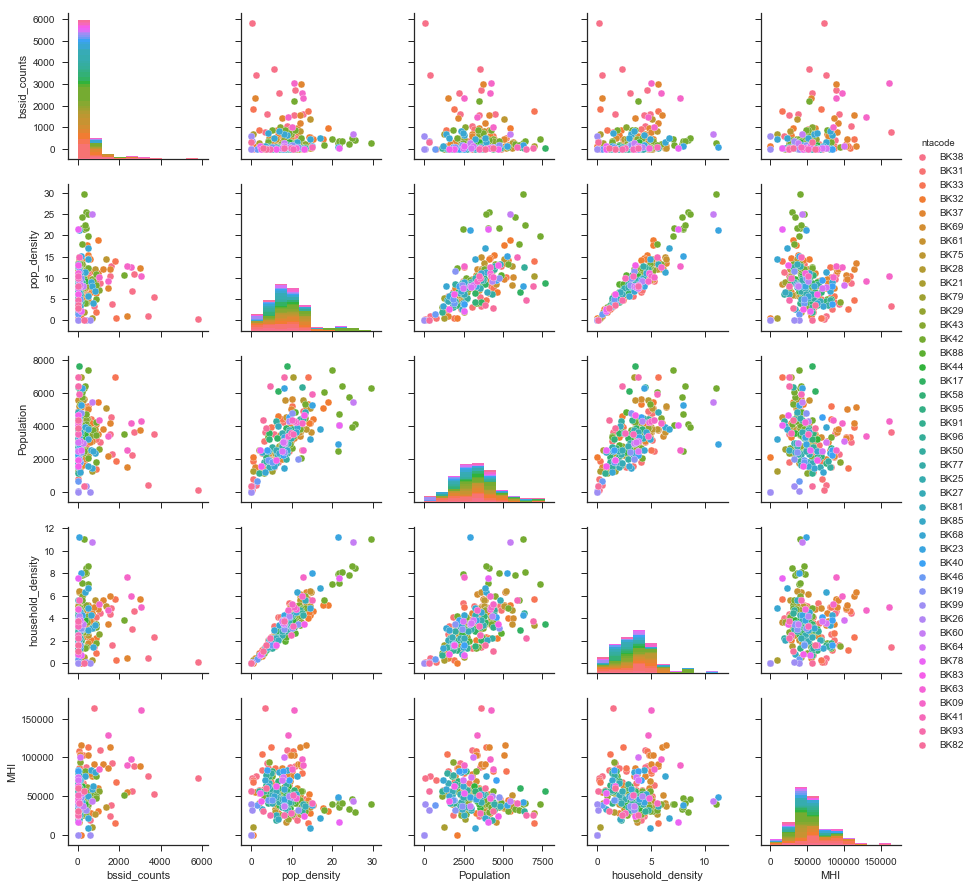

In [1175]:
import seaborn as sns
sns.set(style="ticks")

sns.pairplot(matrix, hue="ntacode")

In [1176]:
import statsmodels.api as sm

In [1208]:
X = NYC_shape_with_wifi_counts_[["pop_density","Population","household_density","MHI"]]
y = NYC_shape_with_wifi_counts_.bssid_counts

In [1209]:
y.describe()

count     249.000000
mean      403.943775
std       709.743704
min         0.000000
25%        33.000000
50%       123.000000
75%       477.000000
max      5819.000000
Name: bssid_counts, dtype: float64

In [1215]:
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

In [1216]:
predictions = model.predict(X)

In [1217]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           bssid_counts   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     5.934
Date:                Thu, 13 Jul 2017   Prob (F-statistic):           0.000142
Time:                        22:14:10   Log-Likelihood:                -1975.9
No. Observations:                 249   AIC:                             3962.
Df Residuals:                     244   BIC:                             3979.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
const               -33.6995    160.101     -0.210      0.833      -349.055   281.656
pop_density          -3.5473     27.693     -0.128      0.898       -58.095    51.001
Population           -0.0282      0.041     -0.693      0.489        -0.108     0.052
household_density    36.4556     67.053      0.544      0.587       -95.621   168.532
MHI                   0.0082      0.002      4.192      0.000         0.004     0.012
==============================================================================
Omnibus:                      218.739   Durbin-Watson:                   1.507
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3840.837
Skew:                           3.510   Prob(JB):                         0.00
Kurtosis:                      20.915   Cond. No.                     2.18e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.18e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
# We can run a logistics regression model and identify the odds you will have open networks where you live
# given the economy of the area (median household income)


# you can calculate the probability P = (odds/(1+odds)) = 0.793/1.793 = 0.442


# Negative binomial model:
# In probability theory and statistics, the negative binomial distribution is a discrete probability distribution of the number of successes in a sequence of independent and identically distributed Bernoulli trials before a specified (non-random) number of failures (denoted r) occurs.

# Or
 
# poisson model:
# Poisson regression assumes the response variable Y has a Poisson distribution, and assumes the logarithm of its expected value can be modeled by a linear combination of unknown parameters. A Poisson regression model is sometimes known as a log-linear model, especially when used to model contingency tables.


# There's more to think about…. 
# (output, resolution, and unit of analysis)

In [1214]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
from statsmodels.genmod.generalized_estimating_equations import GEE
from statsmodels.genmod.cov_struct import (Exchangeable,
    Independence,Autoregressive)
from statsmodels.genmod.families import Poisson

In [1218]:
X = NYC_shape_with_wifi_counts_[["MHI"]]
y = NYC_shape_with_wifi_counts_.bssid_counts

In [1219]:
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

In [1220]:
predictions = model.predict(X)

In [1221]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           bssid_counts   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     22.83
Date:                Thu, 13 Jul 2017   Prob (F-statistic):           3.04e-06
Time:                        22:27:59   Log-Likelihood:                -1976.5
No. Observations:                 249   AIC:                             3957.
Df Residuals:                     247   BIC:                             3964.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        -44.1288    103.222     -0.428      0.669      -247.436   159.178
MHI            0.0084      0.002      4.778      0.000         0.005     0.012
==============================================================================
Omnibus:                      216.894   Durbin-Watson:                   1.492
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3709.897
Skew:                           3.477   Prob(JB):                         0.00
Kurtosis:                      20.585   Cond. No.                     1.40e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.4e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""